# setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "tensorflow"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## 12. Logistic Regression with Mini-Batch Gradient Descent using TensorFlow

First, let's create the moons dataset using Scikit-Learn's `make_moons()` function:

In [2]:
from sklearn.datasets import make_moons

m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

In [3]:
X_moons_with_bias = np.c_[np.ones((m, 1)), X_moons]

In [4]:
y_moons_column_vector = y_moons.reshape(-1, 1)

In [5]:
test_ratio = 0.2
test_size = int(m * test_ratio)
X_train = X_moons_with_bias[:-test_size]
X_test = X_moons_with_bias[-test_size:]
y_train = y_moons_column_vector[:-test_size]
y_test = y_moons_column_vector[-test_size:]

In [6]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

In [7]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

reset_graph()

E:\Users\63092\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The _moons_ dataset has two input features, since each instance is a point on a plane (i.e., 2-Dimensional):

In [8]:
n_inputs = 2

Now let's build the Logistic Regression model. As we saw in chapter 4, this model first computes a weighted sum of the inputs (just like the Linear Regression model), and then it applies the sigmoid function to the result, which gives us the estimated probability for the positive class:

$\hat{p} = h_\boldsymbol{\theta}(\mathbf{x}) = \sigma(\boldsymbol{\theta}^T \mathbf{x})$


Recall that $\boldsymbol{\theta}$ is the parameter vector, containing the bias term $\theta_0$ and the weights $\theta_1, \theta_2, \dots, \theta_n$. The input vector $\mathbf{x}$ contains a constant term $x_0 = 1$, as well as all the input features $x_1, x_2, \dots, x_n$.

Since we want to be able to make predictions for multiple instances at a time, we will use an input matrix $\mathbf{X}$ rather than a single input vector. The $i^{th}$ row will contain the transpose of the $i^{th}$ input vector $(\mathbf{x}^{(i)})^T$. It is then possible to estimate the probability that each instance belongs to the positive class using the following equation:

$ \hat{\mathbf{p}} = \sigma(\mathbf{X} \boldsymbol{\theta})$

That's all we need to build the model:

In fact, TensorFlow has a nice function `tf.sigmoid()` that we can use to simplify the last line of the previous code:

As we saw in chapter 4, the log loss is a good cost function to use for Logistic Regression:

$J(\boldsymbol{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} \log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) \log\left(1 - \hat{p}^{(i)}\right)\right]}$


Now let's start over, but this time we will add all the bells and whistles, as listed in the exercise:
* Define the graph within a `logistic_regression()` function that can be reused easily.
* Save checkpoints using a `Saver` at regular intervals during training, and save the final model at the end of training.
* Restore the last checkpoint upon startup if training was interrupted.
* Define the graph using nice scopes so the graph looks good in TensorBoard.
* Add summaries to visualize the learning curves in TensorBoard.
* Try tweaking some hyperparameters such as the learning rate or the mini-batch size and look at the shape of the learning curve.

In [9]:
X_train_enhanced = np.c_[X_train,
                         np.square(X_train[:, 1]),
                         np.square(X_train[:, 2]),
                         X_train[:, 1] ** 3,
                         X_train[:, 2] ** 3]
X_test_enhanced = np.c_[X_test,
                        np.square(X_test[:, 1]),
                        np.square(X_test[:, 2]),
                        X_test[:, 1] ** 3,
                        X_test[:, 2] ** 3]

In [10]:
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_proba = tf.sigmoid(logits)
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
    return y_proba, loss, training_op, loss_summary, init, saver

Let's create a little function to get the name of the log directory to save the summaries for Tensorboard:

In [11]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

Next, let's create the graph, using the `logistic_regression()` function. We will also create the `FileWriter` to save the summaries to the log directory for Tensorboard:

In [12]:
n_inputs = 2 + 4
logdir = log_dir("logreg")

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


At last we can train the model! We will start by checking whether a previous training session was interrupted, and if so we will load the checkpoint and continue training from the epoch number we saved. In this example we just save the epoch number to a separate file, but in chapter 11 we will see how to store the training step directly as part of the model, using a non-trainable variable called `global_step` that we pass to the optimizer's `minimize()` method.

You can try interrupting training to verify that it does indeed restore the last checkpoint when you start it again.

In [13]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

# checkpoint_path = os.path.join("tmp", "my_logreg_model.ckpt")
checkpoint_path = "my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "my_logreg_model"

with tf.Session(config=config) as sess:
    if os.path.isfile(checkpoint_epoch_path):
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 0.62998503
Epoch: 500 	Loss: 0.16122366
Epoch: 1000 	Loss: 0.1190321
Epoch: 1500 	Loss: 0.097329214
Epoch: 2000 	Loss: 0.08369793
Epoch: 2500 	Loss: 0.07437582
Epoch: 3000 	Loss: 0.06750215
Epoch: 3500 	Loss: 0.062206898
Epoch: 4000 	Loss: 0.058026787
Epoch: 4500 	Loss: 0.05456297
Epoch: 5000 	Loss: 0.051708277
Epoch: 5500 	Loss: 0.04923773
Epoch: 6000 	Loss: 0.047167283
Epoch: 6500 	Loss: 0.045376644
Epoch: 7000 	Loss: 0.04381875
Epoch: 7500 	Loss: 0.042374235
Epoch: 8000 	Loss: 0.041089173
Epoch: 8500 	Loss: 0.039970923
Epoch: 9000 	Loss: 0.038920265
Epoch: 9500 	Loss: 0.038010757
Epoch: 10000 	Loss: 0.037155706


Once again, we can make predictions by just classifying as positive all the instances whose estimated probability is greater or equal to 0.5:

In [14]:
y_pred = (y_proba_val >= 0.5)

In [16]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_test, y_pred)

0.9797979797979798

In [17]:
recall_score(y_test, y_pred)

0.9797979797979798

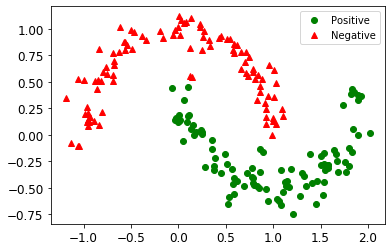

In [18]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

Try starting the tensorboard server, find the latest run and look at the learning curve (i.e., how the loss evaluated on the test set evolves as a function of the epoch number):

```
$ tensorboard --logdir=tf_logs
```

Now you can play around with the hyperparameters (e.g. the `batch_size` or the `learning_rate`) and run training again and again, comparing the learning curves. You can even automate this process by implementing grid search or randomized search. Below is a simple implementation of a randomized search on both the batch size and the learning rate. For the sake of simplicity, the checkpoint mechanism was removed.

In [19]:
# from scipy.stats import reciprocal

# n_search_iterations = 10

# for search_iteration in range(n_search_iterations):
#     batch_size = np.random.randint(1, 100)
#     learning_rate = reciprocal(0.0001, 0.1).rvs(random_state=search_iteration)

#     n_inputs = 2 + 4
#     logdir = log_dir("logreg")
    
#     print("Iteration", search_iteration)
#     print("  logdir:", logdir)
#     print("  batch size:", batch_size)
#     print("  learning_rate:", learning_rate)
#     print("  training: ", end="")

#     reset_graph()

#     X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
#     y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

#     y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(
#         X, y, learning_rate=learning_rate)

#     file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

#     n_epochs = 10001
#     n_batches = int(np.ceil(m / batch_size))

#     final_model_path = "./my_logreg_model_%d" % search_iteration

#     with tf.Session() as sess:
#         sess.run(init)

#         for epoch in range(n_epochs):
#             for batch_index in range(n_batches):
#                 X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
#                 sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
#             loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
#             file_writer.add_summary(summary_str, epoch)
#             if epoch % 500 == 0:
#                 print(".", end="")

#         saver.save(sess, final_model_path)

#         print()
#         y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
#         y_pred = (y_proba_val >= 0.5)
        
#         print("  precision:", precision_score(y_test, y_pred))
#         print("  recall:", recall_score(y_test, y_pred))

The `reciprocal()` function from SciPy's `stats` module returns a random distribution that is commonly used when you have no idea of the optimal scale of a hyperparameter. See the exercise solutions for chapter 2 for more details. 